## Sudoku AI Solver

In this notebook, a sudoku puzzle is extracted from an image using OpenCV and Deep Learning. 

MNIST dataset use. Keras use.

### Package imports



In [1]:
# Disable tensorflow warning messages

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import cv2
import imutils
import copy
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from solve_sudoku import *
from imutils.perspective import four_point_transform
from skimage.segmentation import clear_border

## Markdown

Image processing steps:

- Convert image to grayscale
- Blurring
- Thresholding

In [3]:
def find_puzzle(img, debug=False):
    """
    Extract sudoku puzzle from an image.
    """
    
    #
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (7,7), 3)
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # Find contours in the thresholded image and sort them by size in descending order
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    
    # Initialize a contour that corresponds to the puzzle outline
    puzzle_cnt = None
    
    # Loop over the contours
    for c in cnts:
        # Approximate the coutour
        peri = cv2.arcLength(c, True) #
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        #
        if len(approx) == 4:
            puzzle_cnt = approx
            break
        
    puzzle_outline = img.copy()
    cv2.drawContours(puzzle_outline, [puzzle_cnt], -1, (0, 255, 0), 3)

    # Apply a four point perspective transform to both the original
    # image and grayscale image to obtain a top-down bird's eye view
    # of the puzzle
    color_puzzle = four_point_transform(img, puzzle_cnt.reshape(4,2)) 
    gray_puzzle = four_point_transform(gray, puzzle_cnt.reshape(4,2))  
    
    if debug:
        display_img(img, 'Original Image')
        display_img(thresh, 'Thresholded Image')
        display_img(puzzle_outline, 'Puzzle Outline')
        display_img(gray_puzzle, 'Grayscale Puzzle')
        
    return color_puzzle, gray_puzzle

## Markdown

In [4]:
def extract_digit(cell):
    """
    """
    
    # Apply automatic thresholding to the cell and then clear any
    # connected borders that touch the border of the cell
    
    # In the markdown explain the different threshold options
    
    thresh = cv2.threshold(cell, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1] # 
    thresh = clear_border(thresh)
    
    # Find contours in the thresholded cell
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    # If no contours were found then this is an empty cell
    if len(cnts)==0:
        return None
    
    # Otherwise find the largest contour in the cell and create a mask for the contour
    c = max(cnts, key=cv2.contourArea)
    mask = np.zeros(thresh.shape, dtype="uint8")
    cv2.drawContours(mask, [c], -1, 255, -1)
    
    # Compute the perecentage of masked pixels relative to the total area of the image
    (h, w) = thresh.shape
    percent_filled = cv2.countNonZero(mask) / float(w * h)
    
    # If less than 3% of the mask is filled then we are looking at noise and can safely ignore the contour
    if percent_filled < 0.03:
        return None
    
    # Apply the mask to the thresholded cell
    digit = cv2.bitwise_and(thresh, thresh, mask=mask) # 

    return digit

## Markdown

In [5]:
def generate_cell_locations(step_x, step_y):
    """
    """

    # Initialize a list to store (x,y) coordinates of each cell location
    cell_locs = []

    # Loop over the grid lcoations
    for y in range(9):
        # Initialize the current list of cell locations
        row = []

        for x in range(9):
            # Compute the starting and ending (x,y) coordinates of the current cell
            start_x = x * step_x
            start_y = y * step_y
            end_x = (x + 1) * step_x
            end_y = (y + 1) * step_y

            # Add the (x,y) coordinates to the cell locations list
            row.append((start_x, start_y, end_x, end_y))

            # Crop the cell from the gray_puzzle transformed image and then extract
            # the digit from the cell
            cell = gray_puzzle[start_y:end_y, start_x:end_x]
            digit = extract_digit(cell)

            # Confirm that the digit is not empty
            if digit is not None:
                classify_digit(digit, x, y)

        # Add the row to the cell locations
        cell_locs.append(row)

    return cell_locs

## Markdown

In [6]:
def classify_digit(digit, x, y):
    """
    """
    
    global unsolved_board
    
    # Resize the cell to 28x28 pixels and prepare it classification. 
    # 28x28 is the size of images in the MNIST dataset
    roi = cv2.resize(digit, (28, 28))
    roi = roi.astype("float")/255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0) #

    # Classify the digit and update the sudoku board with the prediction
    pred = model.predict(roi, verbose=0).argmax(axis=1)[0] #
    unsolved_board[y, x] = pred

## Markdown

In [7]:
def display_solutions(cell_locs, color_puzzle):
    """
    """
    
    global board, unsolved_board
    
    # Loop over the cell locations and boards
    for (cell_row, unsolved_board_row, solved_board_row) in zip(cell_locs, unsolved_board, solved_board):
        
        # Loop over individual cells in the row
        for (box, unsolved_digit, solved_digit) in zip(cell_row, unsolved_board_row, solved_board_row):
            if unsolved_digit == 0:
                # Unpack the cell coordinates
                start_x, start_y, end_x, end_y = box

                # Compute the coordinates of where the digit will be drawn on the output puzzle image
                text_x = int((end_x - start_x) * 0.33)
                text_y = int((end_y - start_y) * -0.2)
                text_x += start_x
                text_y += end_y

                # Draw the digit on the sudoku puzzle image
                cv2.putText(
                    color_puzzle, str(solved_digit), (text_x, text_y), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 255), 2)
    
    display_img(color_puzzle, 'Solved Puzzle')

## Markdown

In [8]:
def display_img(img, title):
    """
    Function to display an image with a specified title.
    """
    
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.set_title(title, fontsize=22)
    ax.imshow(img,cmap='gray')

## Markdown

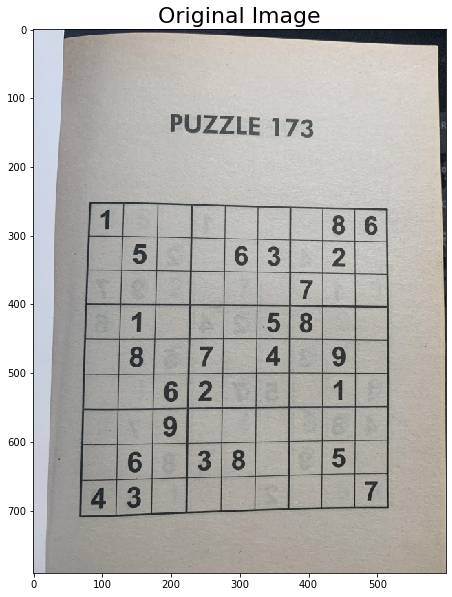

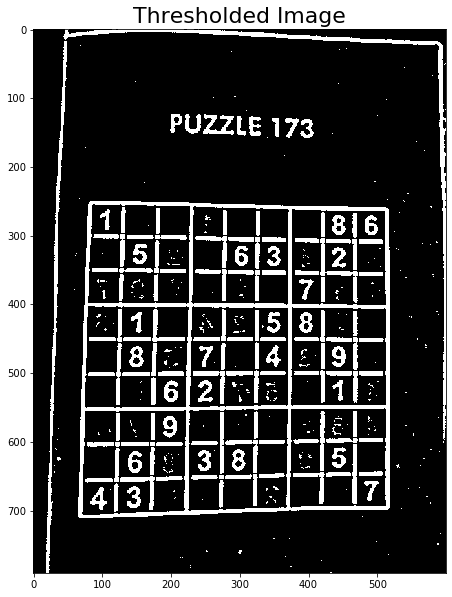

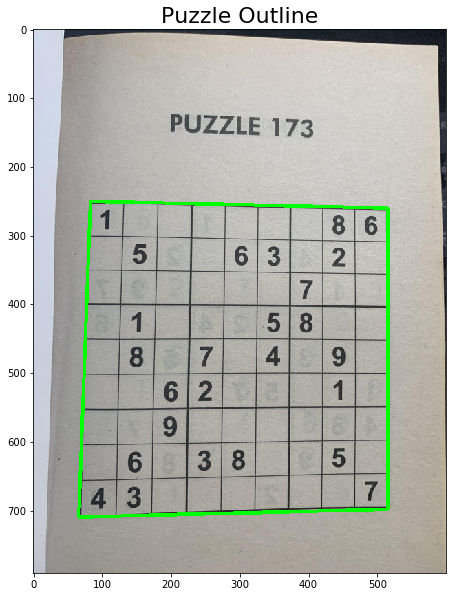

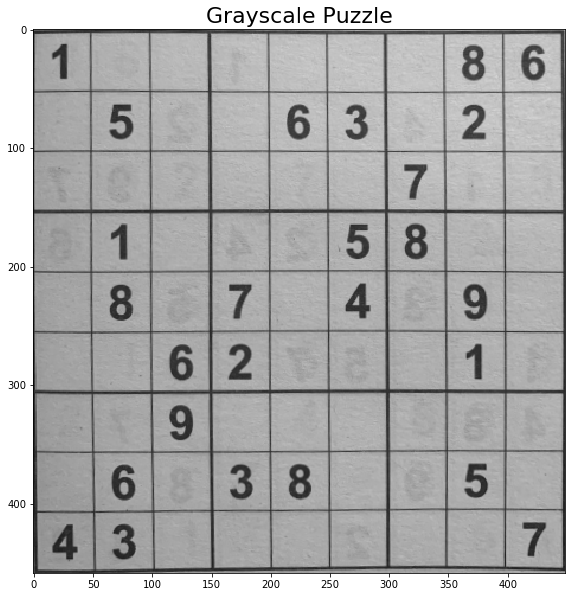

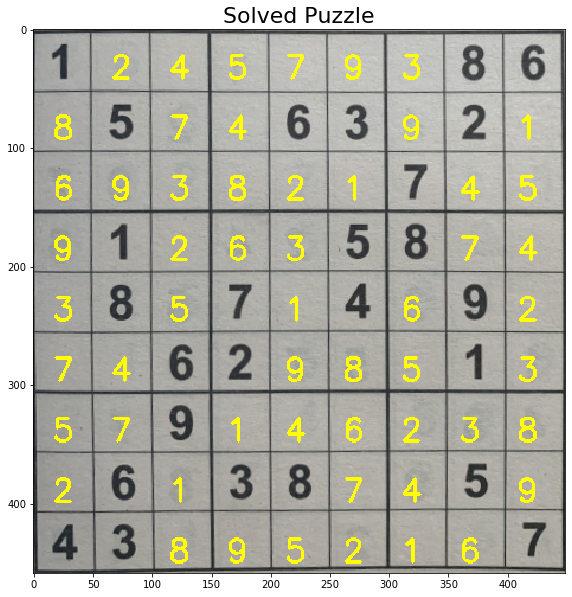

In [9]:
# Main program cell

# Load image; second image is sudoku2.jpg
img = cv2.imread('sudoku_images/sudoku.jpg')
img = imutils.resize(img, width=600)

# Load model to detect digits
model = load_model('model_files/digit_classifier_model.h5')

# Find puzzle in the image. Set debug to False to disable displaying image processing steps.
color_puzzle, gray_puzzle = find_puzzle(img, debug=True)

# Initialize sudoku board
unsolved_board = np.zeros((9,9), dtype='int')

# Sudoku is a 9x9 grid (81 individual cells), location of each cell can be inferred by
# dividing the gray_puzzle image into a 9x9 grid
step_x = gray_puzzle.shape[1] // 9
step_y = gray_puzzle.shape[0] // 9

#
cell_locs = generate_cell_locations(step_x, step_y)

# Convert board to a list before solving the puzzle
unsolved_board = unsolved_board.tolist()

# Create a deep copy of the unsolved_board to be passed into the solve_puzzle() method
unsolved_board_copy = copy.deepcopy(unsolved_board) #

# Solve puzzle
solved_board = solve_puzzle(unsolved_board_copy)

if not solved_board:
    print('\nPuzzle could not be solved, check training model.\n')
else:
    display_solutions(cell_locs, color_puzzle)